# Training a summarization model

Generating accurate summaries of the interactions between a customer and the support center can help improve customer service and detect common pattern among customer requests.

In [1]:
!pip install datasets -q
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
from transformers import pipeline

In [2]:
!pip install py7zr -q

In [3]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write)

In [4]:
dataset_samsum = load_dataset("khwrali011/summary-dataset")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
dataset_samsum

DatasetDict({
    train: Dataset({
        features: ['Transcriptions', 'Summary'],
        num_rows: 1799
    })
    test: Dataset({
        features: ['Transcriptions', 'Summary'],
        num_rows: 200
    })
})

In [6]:
dataset_samsum["train"][:1]

{'Transcriptions': ["This is Abdul calling for an intro. Hi, Abradar, this is Jessica calling from JSK North. I was calling in regards to the patient that we have here. They have a neuro consultant in place. Let me see. And the patient name? Patient's name is George Franklin. Franklin. George Franklin. Are you calling to add a new consultant on this patient, or, like, you already paste in? So they put in the order for it, but they tried calling before to place it in, but no one really answered. That's why I'm trying again. No worries. From Florida, JFK north. It's West Palm beach, right? Correct. So which card we're going to be using for the consult? You said what's the reason? Which card we're going to be using for the console? The camera. Give me 1 second. Yep. Which cart? Like, can you confirm? Like, is it like a routine consult you're calling for or like, calling for a stat consult? Okay, give me 1 second here. Sure. Well, it doesn't really say here whether or not it's routine. It 

In [7]:
split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum]

In [8]:
split_lengths

[1799, 200]

The "dialogue" field contains the full text and the "summary" the summarized dialogue.

In [9]:
print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["Transcriptions"])
print("\nSummary:")
print(dataset_samsum["test"][0]["Summary"])

Split lengths: [1799, 200]
Features: ['Transcriptions', 'Summary']

Dialogue:
Thank you for calling the HCA Healthcare Patient Logistics center. We are currently experiencing higher than normal call volume. Please hold and we will get your call answered in the order it was received. Thank you. For highly emergent transfers such as STeMI, stroke, trauma or burn, press one. For all other medical transfer requests from a hospital, press two. For physician offices or urgent care centers calling to place a patient with our facilities, press three. For mental health assessment requests or mental health transfers, press four. For all HCA distress transportation requests, press five. Please make a valid selection to be connected to the next available coordinator. For highly emergent transfers such as StEMI, stroke, trauma or burn, press one. For all other medical transfer requests from a hospital, press two. For physician offices or urgent care centers calling to place a patient with our facil

# Evaluating PEGASUS on SAMSum

We will run the summarization pipeline with the PEGASUS model to see what the output looks like.

In [10]:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The results are not great, as we can see below.

In [11]:
# pipe_out = pipe(dataset_samsum["test"][0]["Transcriptions"])
# print("Summary:")
# print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))

### Fine-Tuning PEGASUS

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [13]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["Transcriptions"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["Summary"]]
print(max(d_len))
print(max(s_len))

Token indices sequence length is longer than the specified maximum sequence length for this model (1123 > 1024). Running this sequence through the model will result in indexing errors


3076
354


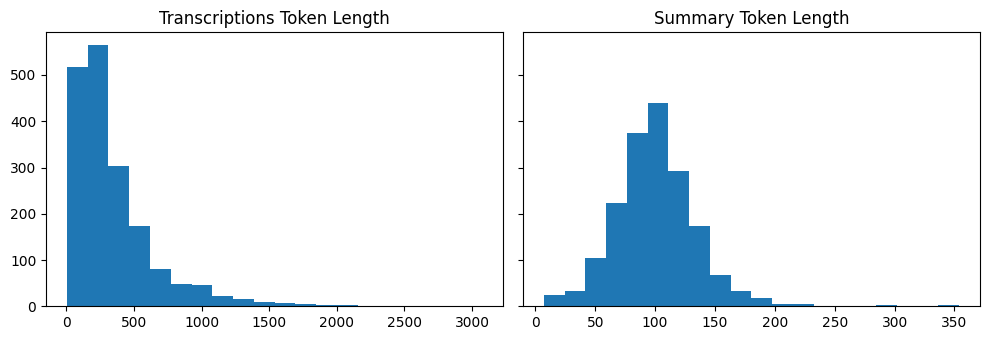

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20)
axes[0].set_title("Transcriptions Token Length")
axes[1].hist(s_len, bins=20)
axes[1].set_title("Summary Token Length")
plt.tight_layout()
plt.show()

In [55]:
tokenizer.as_target_tokenizer()

In [65]:
#lets tokenize the dataset

def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["Transcriptions"], max_length=1024, truncation=True)

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["Summary"], max_length=128, truncation=True)

    return {
        "input_ids": input_encodings["input_ids"],
        "attention_mask": input_encodings["attention_mask"],
        "labels": target_encodings["input_ids"]
    }

In [66]:
dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched=True)

Map:   0%|          | 0/1799 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3921: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [67]:
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

In [68]:
from transformers import DataCollatorForSeq2Seq
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [69]:
!pip install -U accelerate
!pip install -U transformers

In [61]:
from huggingface_hub import notebook_login
notebook_login()

In [70]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="pegasus-samsum-v2",
                                 num_train_epochs=5,
                                 warmup_steps=500,
                                 per_device_train_batch_size=1,
                                 per_gpu_eval_batch_size=1,
                                 weight_decay=0.01,
                                 logging_steps=10,
                                 push_to_hub=True,
                                 evaluation_strategy='steps',
                                 eval_steps=500,
                                 save_steps=500,
                                 gradient_accumulation_steps=4,
                                 report_to="none") #wandb disabled)

In [72]:
# trainer = Trainer(model=model,
#                  args=training_args,
#                  tokenizer=tokenizer,
#                  data_collator=seq2seq_data_collator,
#                  train_dataset=dataset_samsum_pt["train"],
#                  eval_dataset=dataset_samsum_pt["test"])

In [73]:
# trainer.train()

In [29]:
# trainer.push_to_hub("Training complete.")

# Fine-tuned model evaluation

In [ ]:
# from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# model_ckpt = "khwrali011/pegasus-samsum"
# tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
# model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [ ]:
# !pip install rouge_score -q

In [ ]:
# from datasets import load_metric
# from tqdm import tqdm

# rouge_metric = load_metric("rouge")
# rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

In [ ]:
# def chunks(list_of_elements, batch_size):
#     """Yield successive batch-sized chunks from list_of_elements."""
#     for i in range(0, len(list_of_elements), batch_size):
#         yield list_of_elements[i : i + batch_size]

In [ ]:
# def evaluate_summaries_pegasus(dataset, metric, model, tokenizer, batch_size=4, device=device,
#                                    column_text="article",
#                                    column_summary="highlights"):

#     article_batches = list(chunks(dataset[column_text], batch_size))
#     target_batches = list(chunks(dataset[column_summary], batch_size))

#     for article_batch, target_batch in tqdm(zip(article_batches, target_batches), total=len(article_batches)):
#             inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
#                             padding="max_length", return_tensors="pt")
#             print(type(article_batch))
#             summaries = model.generate(input_ids=inputs["input_ids"].to(device),
#                              attention_mask=inputs["attention_mask"].to(device),
#                              length_penalty=0.8, num_beams=8, max_length=128)
#             decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
#                                     clean_up_tokenization_spaces=True) for s in summaries]

#             decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
#             metric.add_batch(predictions=decoded_summaries, references=target_batch)

#     score = metric.compute()

#     return score

In [ ]:
# score = evaluate_summaries_pegasus(dataset_samsum["test"], rouge_metric, model, tokenizer, column_text="Transcriptions", column_summary="Summary", batch_size=8)
# rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)

In [ ]:
# import pandas as pd
# pd.DataFrame.from_records(rouge_dict, index=[f"pegasus"])

# Generating Dialogue Summaries

In [76]:
from transformers import pipeline
model_ckpt = "khwrali011/pegasus-samsum"
gen_kwargs = {"length_penalty": 0.8,
             "num_beams": 8,
             "max_length": 128}
pipe = pipeline("summarization", model=model_ckpt)

model.safetensors:   9%|8         | 199M/2.28G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.1k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/6.60M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

In [89]:
sample_text = dataset_samsum["test"][90]["Transcriptions"]
reference = dataset_samsum["test"][90]["Summary"]

In [90]:
print("Transcription:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Transcription:
Telespecial sister George, are you calling in a stroke alert? No. How can I help you? Hello, yes, I'm just trying to get a hold of doctor Vahid Bev Ravan. Oh, absolutely. Is this in regards to a patient he's seen on rounds today? For you, sir, yes. Okay, what facility are you at, please? Krista Sponshel. Okay, and what is the best contact number, sir? 361-985-5376 and what is your patient's first and last name? Last name is Sanchez. First name. John. Okay, John, let me see if I can pull up his. It's his date of birth. 332,002. Yes, that's correct. Oh, perfect. And what is the best. Your callback number? 361-985-5376 correct? Yes, ma'am. And what is your name, sir? Aries. A r I e s? Yes, ma'am, that's correct. And doctor? Correct, sir? No, I'm a nurse. Oh, nurse. Okay, let me change that to a nurse to doctor. Give me 1 second. Aries, let me. Okay, just to verify, we have a doctor, director, callback at Spawn south. Callback 361-985-5376 for Mister John Sanchez. Date of bi

### Trying a custom input

In [88]:
custom_dialogue = """this is niki
"""

print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 128, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


There is not enough information in the call to generate a summary. The call appears to be incomplete and lacks important details such as the caller's identity, hospital name, call back number, and relevant numbers or names.
